# PSD Analysis Beta R

## Load necessary libraries
If any of these don't load, you'll need to install them. Assuming you installed Jupyter through Anaconda, you would do the following to install a package
`conda install -c r r-[pkgName]`
e.g., to install ggplot2 you would do:
`conda install -c r r-ggplot2`

In [1]:
R.home()

[1] "/opt/conda/lib/R"

In [2]:
library(ggplot2)
library(mgcv)
library(parallel)
library(plyr)
library(tidyr)
library(data.table)
library(viridis)
# library(ggthemes)
library(nlme)

Loading required package: nlme
This is mgcv 1.8-29. For overview type 'help("mgcv-package")'.
Loading required package: viridisLite


## Load Data

In [3]:
topdir = getwd()
source(paste(topdir,'/NCIL_functions.R',sep=""))
num_cores = 4

dat = read.csv("osc_data/beta.csv")

head(dat)

X,Subj,PSD,Stim,Channel,Condition,Region,Band,Electrode_by_Subj,Stim_by_Subj,Cond_by_Subj
<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
0,1,-126.5685,standard,POz,MW1,occipital,beta,POz_1,standard_1,MW1_1
1,1,-125.5770,standard,POz,MW1,occipital,beta,POz_1,standard_1,MW1_1
2,1,-124.5322,standard,POz,MW1,occipital,beta,POz_1,standard_1,MW1_1
3,1,-126.8013,standard,POz,MW1,occipital,beta,POz_1,standard_1,MW1_1
4,1,-126.7084,standard,POz,MW1,occipital,beta,POz_1,standard_1,MW1_1
5,1,-130.4553,standard,POz,MW1,occipital,beta,POz_1,standard_1,MW1_1


In [4]:
summary(dat)

       X              Subj            PSD               Stim      
 Min.   :    0   Min.   : 1.00   Min.   :-140.6   oddball :10439  
 1st Qu.:17956   1st Qu.:12.00   1st Qu.:-127.5   standard:61386  
 Median :35912   Median :24.00   Median :-125.4                   
 Mean   :35912   Mean   :23.99   Mean   :-125.3                   
 3rd Qu.:53868   3rd Qu.:36.00   3rd Qu.:-123.2                   
 Max.   :71824   Max.   :47.00   Max.   :-103.7                   
                                                                  
    Channel      Condition         Region        Band       Electrode_by_Subj
 CPz    : 5525   MW1:22334   frontal  :27625   beta:71825   CPz_43 :  154    
 F3     : 5525   MW2:24960   occipital:22100                F3_43  :  154    
 F4     : 5525   MW3: 3419   parietal :22100                F4_43  :  154    
 Fp1    : 5525   MW4:15613                                  Fp1_43 :  154    
 Fp2    : 5525   MW5: 5499                                  Fp2_43 :  154 

## Run initial full model to identify and remove outliers

Now run the model

In [5]:
m0 <- bam(PSD ~ Stim * Condition
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

In [6]:
dat <- romr.fnc(m0, dat, trim=2.5)$data

m1 <- bam(PSD ~ Stim * Condition 
          + s(Subj, bs="re"),
          data = dat, 
          samfrac=0.1)

n.removed = 1307 
percent.removed = 1.819701 


#### Find and remove outliers, then update model


Method: fREML   Optimizer: perf newton
full convergence after 12 iterations.
Gradient range [-1.603294e-05,1.600178e-05]
(score 186906.4 & scale 10.65614).
Hessian positive definite, eigenvalue range [0.4993666,35908.5].
Model rank =  9 / 11 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

           k'   edf k-index p-value    
s(Subj) 1.000 0.999    0.62  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


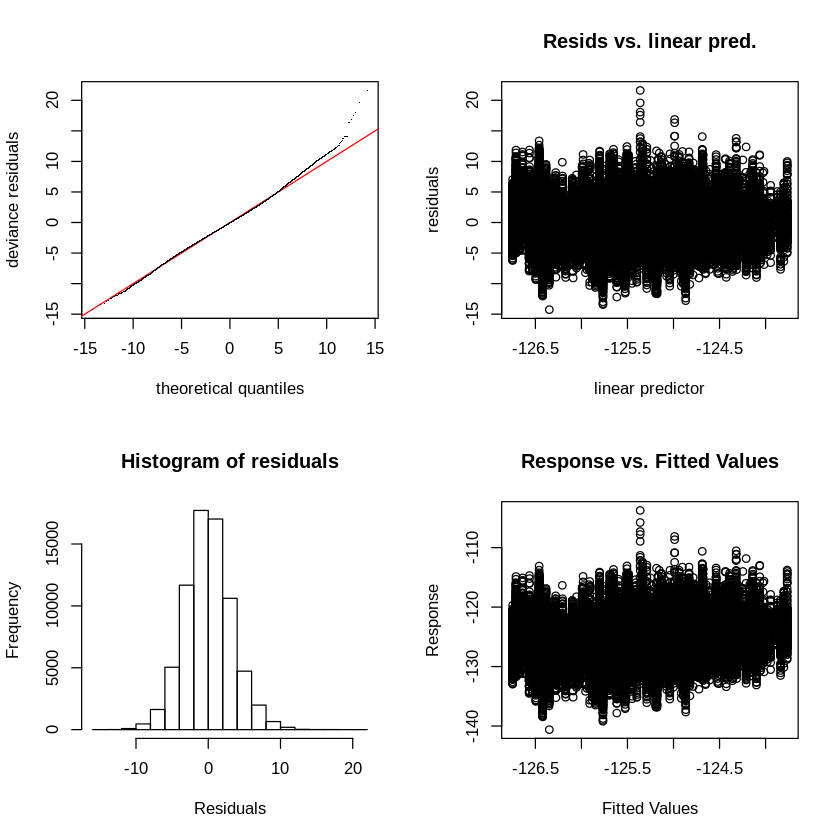

In [7]:
gam.check(m0)


Method: fREML   Optimizer: perf newton
full convergence after 12 iterations.
Gradient range [-6.816161e-05,6.80526e-05]
(score 178192.7 & scale 9.165416).
Hessian positive definite, eigenvalue range [0.4995359,35255].
Model rank =  9 / 11 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

           k'   edf k-index p-value    
s(Subj) 1.000 0.999    0.65  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


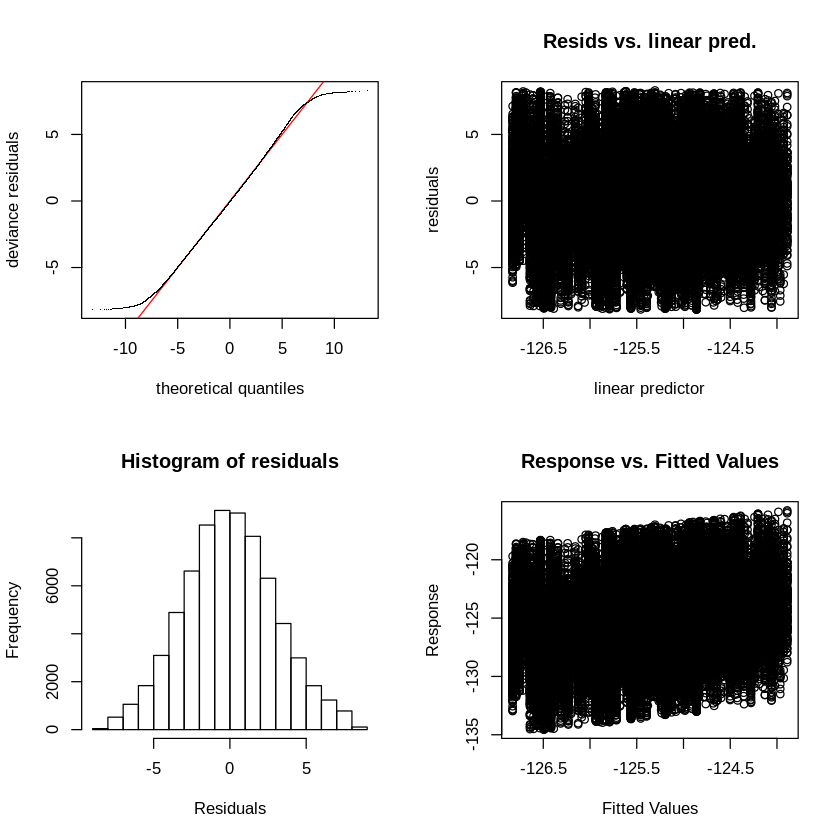

In [8]:
gam.check(m1)

## Compute LME usind data from the frontal region

In [9]:
bdat <- dat

In [10]:
dat <- bdat

In [11]:
dat <- subset(dat, Region == 'frontal') #change this as needed

# relevel data to focus on standard and MW1

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'standard')

In [12]:
summary(dat)

       X              Subj            PSD               Stim      
 Min.   :  448   Min.   : 1.00   Min.   :-134.6   standard:23095  
 1st Qu.:18339   1st Qu.:12.00   1st Qu.:-127.2   oddball : 3927  
 Median :36220   Median :24.00   Median :-124.9                   
 Mean   :36213   Mean   :24.08   Mean   :-125.0                   
 3rd Qu.:54161   3rd Qu.:36.00   3rd Qu.:-122.8                   
 Max.   :71824   Max.   :47.00   Max.   :-115.8                   
                                                                  
    Channel     Condition        Region        Band       Electrode_by_Subj
 Fp2    :5427   MW1:8394   frontal  :27022   beta:27022   F3_43  :  154    
 Fz     :5418   MW2:9387   occipital:    0                F4_43  :  154    
 F3     :5398   MW3:1279   parietal :    0                Fp1_43 :  154    
 F4     :5398   MW4:5862                                  Fp2_43 :  154    
 Fp1    :5381   MW5:2100                                  Fz_43  :  154    
 CPz    

### Try many models

In [13]:
num_cores = 4

cl <- makeCluster(num_cores)

m1r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m2r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m3r <- bam(PSD ~ Stim * Condition   
          + s(Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m4r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Stim_by_Subj, bs="re"), 
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m5r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

m6r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Stim_by_Subj, bs="re") 
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

### Select best model based on AIC

In [14]:
AICtab = as.data.frame(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r))
minAIC =  min(AIC(m0,m1r,m2r,m3r,m4r,m5r,m6r)[2]) 

AICtab$deltaAIC = lapply(AICtab$AIC, deltaAICfunc)
AICtab$deltaAIC = as.numeric(AICtab$deltaAIC)

AICtab$L= lapply(AICtab$deltaAIC, f)
AICtab$L = as.numeric(AICtab$L)

sumlike = sum(AICtab$L)

AICtab$wAIC = lapply(AICtab$L, wAICfunc)
AICtab$wAIC = as.numeric(AICtab$wAIC)

# compute relative likelihood of each model relative to model with smallest AIC/max wAIC
# So, xBetter is interpreted as "the best model is x times more likely than this model"
wAICmax = max(AICtab$wAIC)
AICtab$xBetter = lapply(AICtab$wAIC, xBetterfunc)
AICtab$xBetter = as.numeric(AICtab$xBetter)

AICtab = AICtab[order(AICtab$deltaAIC),] 
AICtab[,c('df','AIC','deltaAIC','xBetter')]

,df,AIC,deltaAIC,xBetter
,<dbl>,<dbl>,<dbl>,<dbl>
m5r,351.9949,111179.0,0.000,1.000000e+00
m4r,282.6645,112191.8,1012.829,8.571439e+219
m1r,241.8061,112382.1,1203.089,1.767571e+261
m6r,199.1155,121008.1,9829.062,Inf
m3r,174.3419,121048.4,9869.421,Inf
m2r,100.2624,121683.4,10504.434,Inf
m0,10.0000,373789.3,262610.253,Inf


### Get summary of the best model
Main effects and interactions. 

In [15]:
mod = m5r

mod_summary = anova(mod)

mod_summary


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric Terms:
               df     F p-value
Stim            1 7.872 0.00502
Condition       4 0.725 0.57473
Stim:Condition  2 0.447 0.63985

Approximate significance of smooth terms:
                          edf   Ref.df        F p-value
s(Subj)                0.9418   1.0000    0.942 3.4e-05
s(Electrode_by_Subj) 226.3965 234.0000 3558.211 < 2e-16
s(Cond_by_Subj)      115.3090 168.0000  798.460 < 2e-16

In [16]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric coefficients:
                           Estimate Std. Error  t value Pr(>|t|)    
(Intercept)              -126.17579    0.34321 -367.636  < 2e-16 ***
Stimoddball                 0.15926    0.05676    2.806  0.00502 ** 
ConditionMW2                0.22931    0.16652    1.377  0.16852    
ConditionMW3                0.12998    0.18913    0.687  0.49194    
ConditionMW4                0.26440    0.18386    1.438  0.15043    
ConditionMW5                0.28811    0.24989    1.153  0.24893    
Stimoddball:ConditionMW2    0.00000    0.00000       NA       NA    
Stimoddball:ConditionMW3    0.00000    0.00000       NA       NA    
Stimoddball:ConditionMW4   -0.07934    0.08796   -0.902  0.36706    
Stimoddball:ConditionMW5   -0.06633    0.12363   -0.536  0.59162    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0

### Compare MW1 oddball instead

In [17]:
# relevel data to focus on standard and MW1

dat[,'Condition'] <- relevel(dat[,'Condition'],'MW1')
dat[,'Stim'] <- relevel(dat[,'Stim'],'oddball')

cl <- makeCluster(num_cores)

m7r <- bam(PSD ~ Stim * Condition  
           + s(Subj, bs="re") 
           + s(Electrode_by_Subj, bs="re")  
           + s(Cond_by_Subj, bs="re"),
          data = dat, 
          samfrac=0.1, cluster=cl, gc.level=2)

stopCluster(cl)

In [18]:
mod = m7r

mod_summary = anova(mod)

mod_summary


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric Terms:
               df     F p-value
Stim            1 7.872 0.00502
Condition       4 0.524 0.71826
Stim:Condition  2 0.447 0.63985

Approximate significance of smooth terms:
                          edf   Ref.df        F p-value
s(Subj)                0.9418   1.0000 603976.3 3.4e-05
s(Electrode_by_Subj) 226.3965 234.0000   3554.7 < 2e-16
s(Cond_by_Subj)      115.3090 168.0000    773.4 < 2e-16

In [19]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
PSD ~ Stim * Condition + s(Subj, bs = "re") + s(Electrode_by_Subj, 
    bs = "re") + s(Cond_by_Subj, bs = "re")

Parametric coefficients:
                            Estimate Std. Error  t value Pr(>|t|)    
(Intercept)               -126.01653    0.34638 -363.806  < 2e-16 ***
Stimstandard                -0.15926    0.05676   -2.806  0.00502 ** 
ConditionMW2                 0.22931    0.16652    1.377  0.16852    
ConditionMW3                 0.12998    0.18913    0.687  0.49194    
ConditionMW4                 0.18506    0.19754    0.937  0.34886    
ConditionMW5                 0.22179    0.26996    0.822  0.41135    
Stimstandard:ConditionMW2    0.00000    0.00000       NA       NA    
Stimstandard:ConditionMW3    0.00000    0.00000       NA       NA    
Stimstandard:ConditionMW4    0.07934    0.08796    0.902  0.36706    
Stimstandard:ConditionMW5    0.06633    0.12363    0.536  0.59162    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’